In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Lecture 16: Simple RNN

##  Weather Data

<img src='../../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

2024-05-29 15:04:27.313146: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 15:04:27.392963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:04:27.393007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:04:27.394115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 15:04:27.402064: I tensorflow/core/platform/cpu_feature_guar

In [3]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [4]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid(True);
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid(True);
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [5]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/input' # location where input data is stored
outDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 13/output' # location to store outputs
modelDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 13/models'
subDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/input/flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 50 # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 10
FACTOR_LR = 0.1
BATCH_SIZE = 32 # inline of Training Rows being 60000
IMG_HEIGHT = 190
IMG_WIDTH = 190
REG_LAMBDA = 0.005
L1_LAMBDA = 0.005
L2_LAMBDA = 0.005

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-05-29 15:04:29.778517: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
print (physical_devices)

[]


In [8]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir)):
    os.makedirs(os.path.join(modelDir))
    print ('Created {} directory'.format(os.path.join(modelDir)))

## Load Dataset

In [9]:
'''
for colab users
import pathlib 
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)
'''

'\nfor colab users\nimport pathlib \ndataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\n\ndata_dir = tf.keras.utils.get_file(origin=dataset_url,\n                                   fname=\'flower_photos\',\n                                   untar=True)\ndata_dir = pathlib.Path(data_dir)\n'

In [10]:
data_dir = os.path.join(inpDir, subDir)
data_dir

'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/input/flower_photos'

In [11]:
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'daisy', 'roses']

In [12]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels
    unique, _, counts = tf.unique_with_counts(train_ler', color = 'Orange')
    plt.xticks(range(len(unique)), class_names)
    plt.title('Test Set')


In [13]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

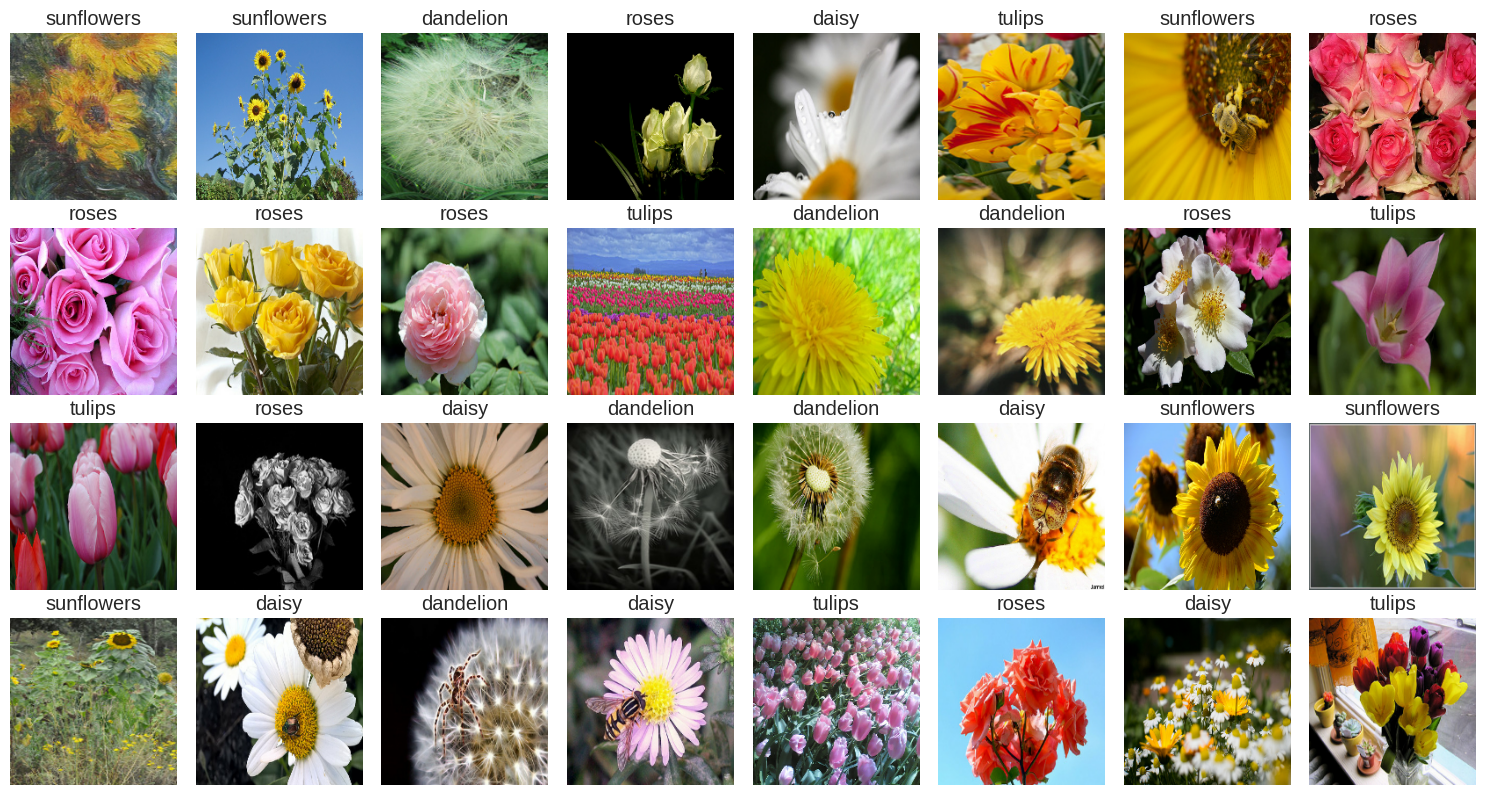

In [15]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):

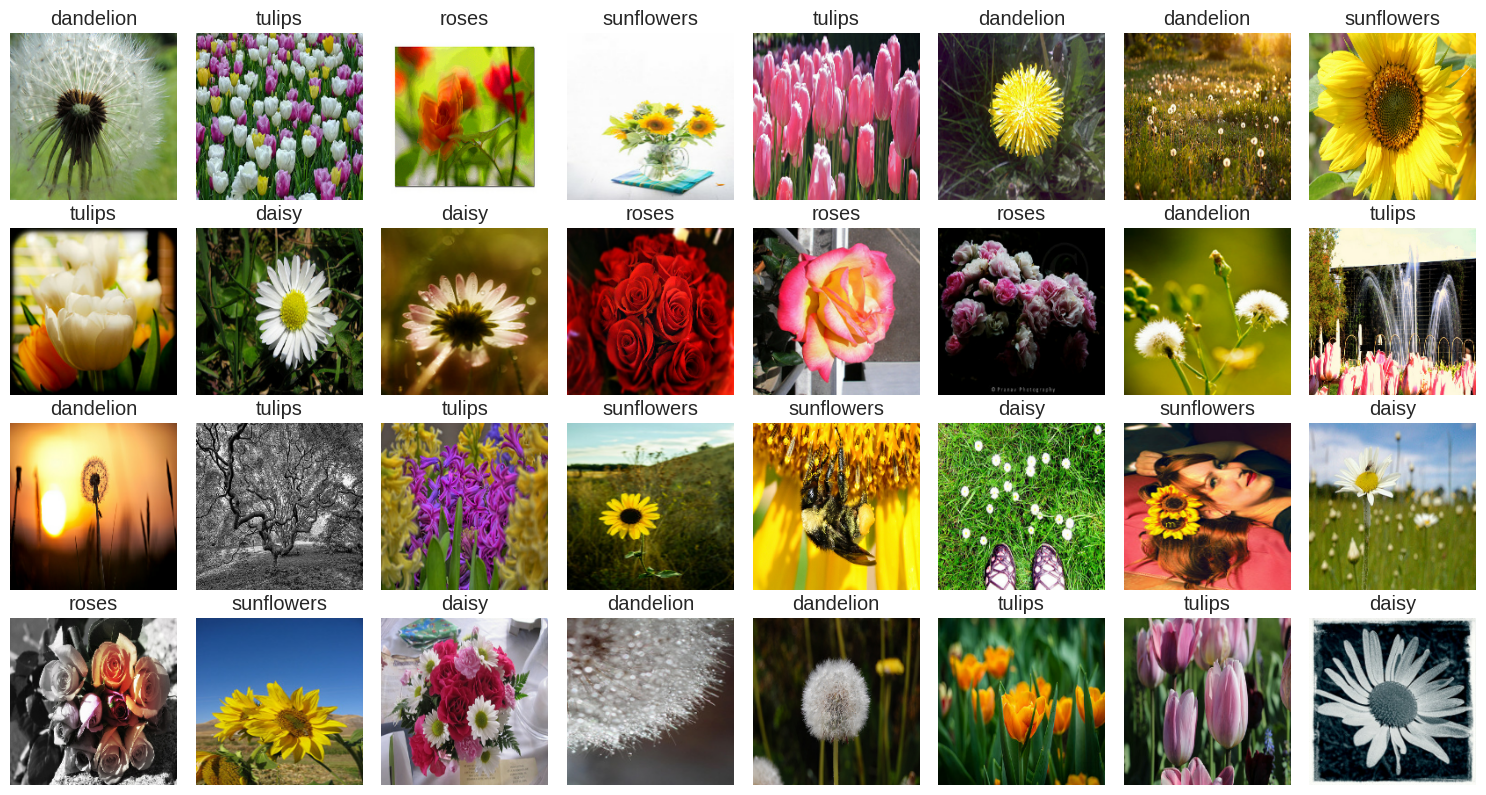

In [16]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    for i in range (BATCH_SIZE): # loop over batch
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        plt.grid(False) # no to grid
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()

plt.show()#Inittialize out optimizer and loss function
# optimizer = torch.optim.AdamW(model.parameters(),
#                              lr = ALPHA)

# }
# print('done')

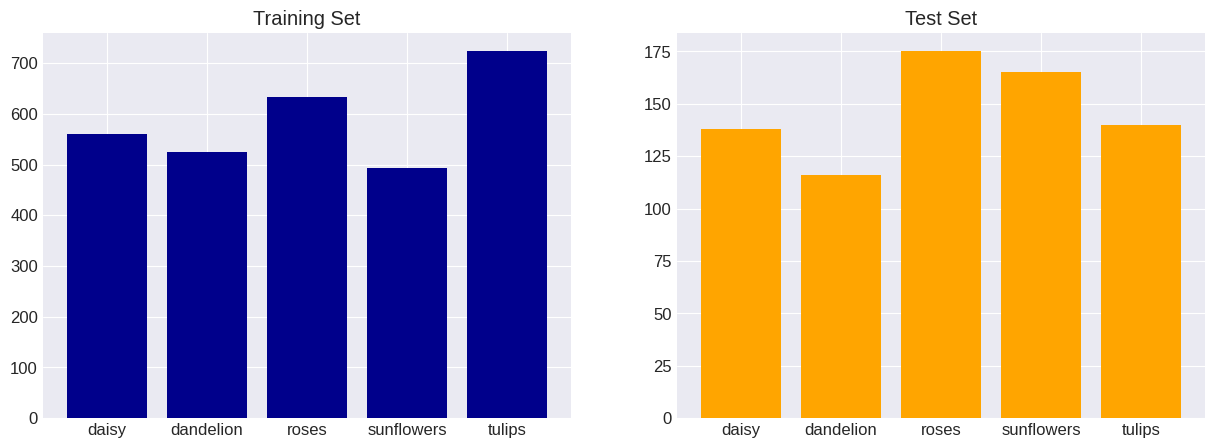

In [17]:
fn_plot_label(train_ds, test_ds)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(190, 190, 3)

## Delete these lines

In [19]:
###------------------------------------------------------------------------------
# labels = []
# for count, data in enumerate(train_ds):

#   imgs, lbls = data
#   # print(count, ':', imgs.shape, lbls.shape)
#   labels.append(lbls)
# ###------------------------------------------------------------------------------

# unique, A, counts = tf.unique_with_counts(tf.concat(labels, axis = 0).numpy())
# print(unique, A, counts)

In [26]:
def build_model(input_shape, num_classes):

  dor1 = 0.2
  dor2 = 0.2
  dor3 = 0.3
  dor4 = 0.3
  dor5 = 0.4
  dor6 = 0.4
  dor7 = 0.5
  dor8 = 0.5

  k_reg = tf.keras.regularizers.L1L2(l1=L1_LAMBDA, l2=L2_LAMBDA)

  kernel_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
  model = tf.keras.Sequential()

  ##############################################################
  # Pre-processing
  ##############################################################

  model.add(tf.keras.layers.Rescaling(1./255.))

  ##############################################################
  # Convolutional Layers
  ##############################################################

  #####Set 1 #####
  
  model.add(tf.keras.layers.Conv2D(32, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init,
                                   activation = 'relu', input_shape = input_shape)) 
  # Expected output: 128x128x32
  model.add(tf.keras.layers.Dropout(dor1))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  # Expected output: 64x64x32

  ##### Set 2 #####
  model.add(tf.keras.layers.Conv2D(64, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init,
                                   activation = 'relu')) 
  # Expected output: 64x64x64
  model.add(tf.keras.layers.Dropout(dor2))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  # Expected output: 32x32x64

  ##### Set 3 #####
  model.add(tf.keras.layers.Conv2D(128, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init,
                                   activation = 'relu')) 
  # Expected output: 32x32x128
  model.add(tf.keras.layers.Dropout(dor3))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  # Expected output: 16x16x128

  ##### Set 4 #####
  model.add(tf.keras.layers.Conv2D(256, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init, 
                                   activation = 'relu')) 
  # Expected output: 16x16x256
  model.add(tf.keras.layers.Dropout(dor4))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  # Expected output: 8x8x256

  ##### Set 5 #####
  model.add(tf.keras.layers.Conv2D(512, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init, 
                                   activation = 'relu')) 
  # Expected output: 8x8x512
  model.add(tf.keras.layers.Dropout(dor5))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  # Expected output: 4x4xx512

  ##### Set 6 #####
  model.add(tf.keras.layers.Conv2D(1024, (3,3), # Number of filters and filter size
                                   kernel_initializer = kernel_init, 
                                   activation = 'relu')) 
  # Expected output: 2x2x1024
  model.add(tf.keras.layers.Dropout(dor6))

  ##############################################################
  # Dense Layers
  ##############################################################

  model.add(tf.keras.layers.Flatten())

  # Dense 1
  model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = k_reg))
  model.add(tf.keras.layers.Dropout(dor7))

  # Dense 2
  model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = k_reg))
  model.add(tf.keras.layers.Dropout(dor8))

  # Dense 3
  model.add(tf.keras.layers.Dense(num_classes))

  return model

In [27]:
num_classes = len(class_names)

In [28]:
model =  build_model(input_shape, num_classes)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
checkpoint_path=os.path.join(modelDir, '')


model_checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
#   save_freq='epoch',
#   initial_value_threshold=None
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0,
    patience=PATIENCE,
    verbose=1,
    mode='auto',
    # baseline=None,
    restore_best_weights=True
    # start_from_epoch=0
)

learning_rate_callback  = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto',
    #min_delta=0.0001,
    #cooldown=0,
    min_lr=0.00001,
    # **kwargs
)


In [31]:
history = model.fit( train_ds,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [model_checkpoint_callback, 
                                 early_stopping_callback, 
                                 learning_rate_callback],
                    validation_data = test_ds)

Epoch 1/50


92/92 [==============================] - ETA: 0s - loss: 38.1738 - accuracy: 0.2381
Epoch 1: val_loss improved from inf to 3.88728, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 13/models/
92/92 [==============================] - 64s 677ms/step - loss: 38.1738 - accuracy: 0.2381 - val_loss: 3.8873 - val_accuracy: 0.2398 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 3.1959 - accuracy: 0.2667
Epoch 2: val_loss improved from 3.88728 to 2.94592, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 13/models/
92/92 [==============================] - 61s 658ms/step - loss: 3.1959 - accuracy: 0.2667 - val_loss: 2.9459 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 2.8314 - accuracy: 0.3283
Epoch 3: val_loss improved from 2.94592 to 2.85437, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 13/models/
92/92 [=====

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 32)      896       
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 94, 94, 32)        0         
 D)                                                              
                                                        

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df

loss  accuracy  val_loss  val_accuracy      lr
0   1.593935  0.241826  1.485785      0.307902  0.0010
1   1.283789  0.424728  1.167371      0.500000  0.0010
2   1.081277  0.558242  1.072669      0.565395  0.0010
3   0.987896  0.600477  1.018852      0.580381  0.0010
4   0.887027  0.646117  1.050214      0.595368  0.0010
5   0.815045  0.677793  0.886567      0.641689  0.0010
6   0.767495  0.708447  0.935255      0.645777  0.0010
7   0.695650  0.727180  0.867714      0.647139  0.0010
8   0.617773  0.767030  0.860916      0.674387  0.0010
9   0.576378  0.778270  0.894076      0.686648  0.0010
10  0.508171  0.811308  0.881728      0.705722  0.0010
11  0.424733  0.842984  0.955749      0.704360  0.0010
12  0.360003  0.871253  1.009100      0.671662  0.0010
13  0.275570  0.904292  1.173329      0.694823  0.0010
14  0.215163  0.927452  1.358961      0.678474  0.0010
15  0.243963  0.918937  1.548641      0.664850  0.0010
16  0.210375  0.927793  1.754762      0.678474  0.0010
17  0.136901  0.950954  1.621601      0.702997  0.0010
18  0.114641  0.961172  1.738289      0.675749  0.0010
19  0.070441  0.979564  1.619889      0.700273  0.0001
20  0.026506  0.993529  1.686236      0.696185  0.0001
21  0.019371  0.995572  1.754514      0.698910  0.0001
22  0.015127  0.996253  1.820705      0.700273  0.0001
23  0.012071  0.997275  1.902843      0.701635  0.0001
24  0.009680  0.997616  1.998718      0.700273  0.0001
25  0.007765  0.997956  2.094584      0.698910  0.0001
26  0.006234  0.997956  2.177703      0.700273  0.0001
27  0.005074  0.998978  2.259218      0.702997  0.0001
28  0.004031  0.998978  2.341877      0.701635  0.0001

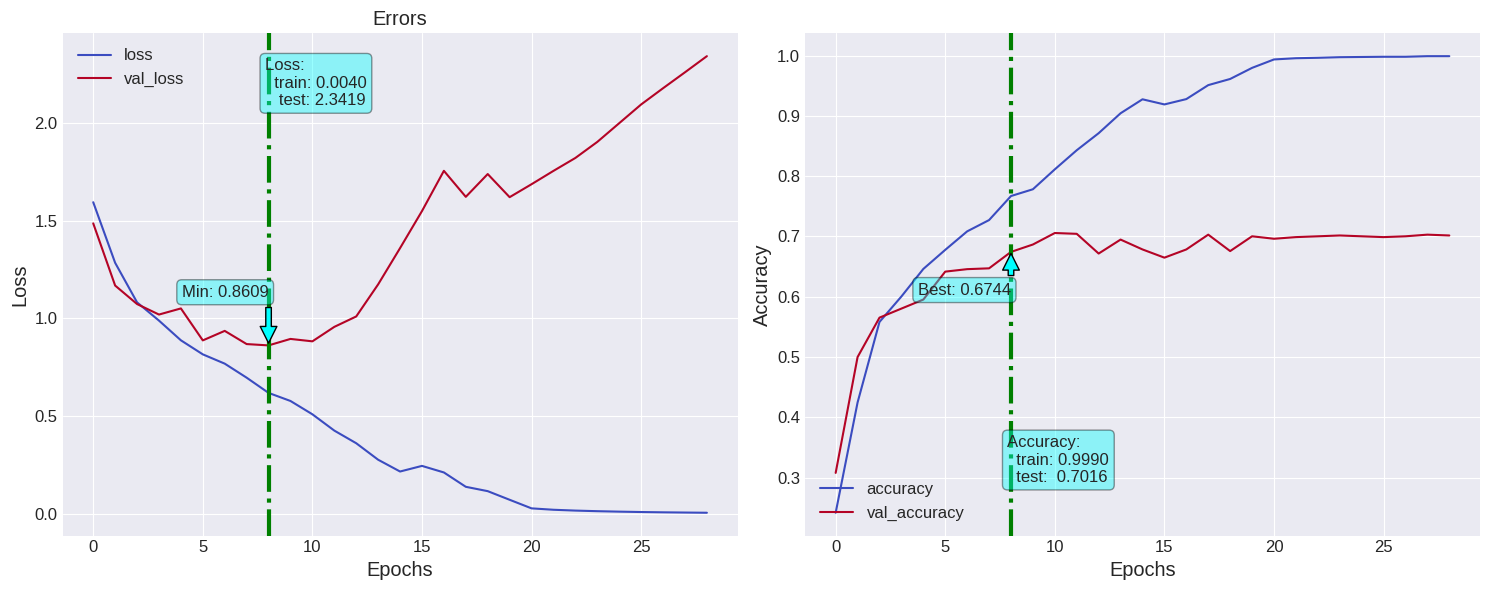

In [ ]:
fn_plot_tf_hist(loss_df)

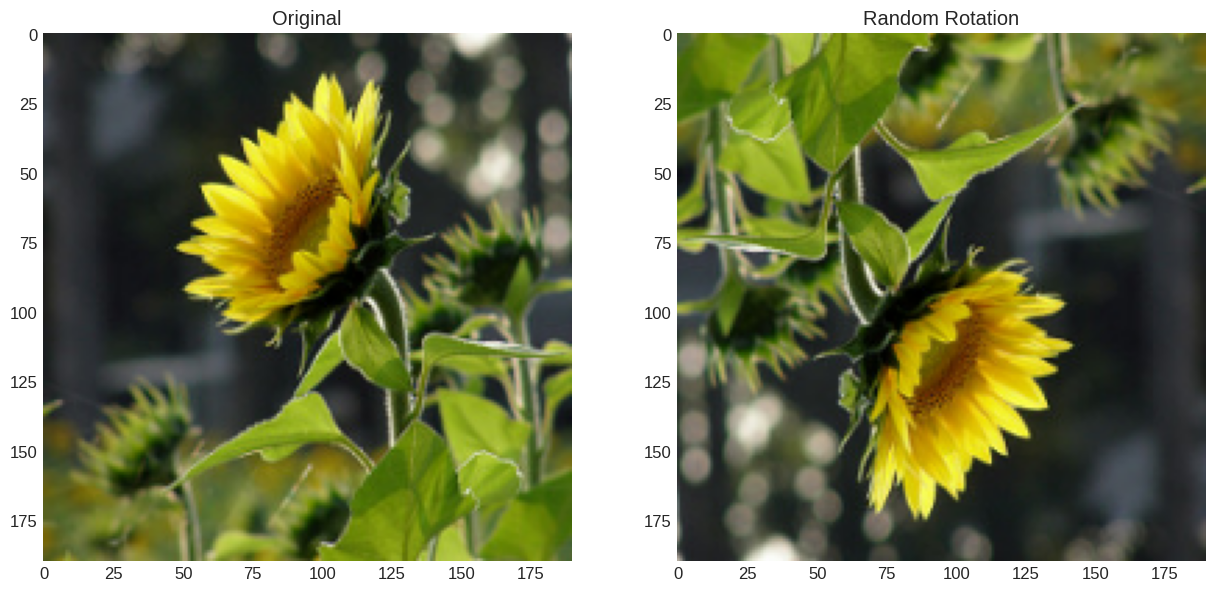

In [ ]:
layer = tf.keras.layers.RandomRotation((0.5, 0.5), fill_mode='nearest', seed=RANDOM_STATE)

img_num = 0

for image,labels in train_ds.take(1):

  out_image = layer(image)

  plt.figure(figsize=(15,8))

  plt.subplot(1,2,1)
  plt.title('Original')
  plt.grid(False)
  plt.imshow(image[img_num].numpy().astype('uint8'))

  plt.subplot(1,2,2)
  plt.title('Random Rotation')
  plt.grid(False)
  plt.imshow(out_image[img_num].numpy().astype('uint8'))

- l1, l2
- dropout- independently
- batch norm